# Some Standardized shocks to illustrate the main macroeconomic features of the model

This notebook performs a set of standard macroeconomic shocks on a model and displays results.  It can be used to verify the good functioning of the model and also illustrates nicely how to perform simulations on World Bank models in python using the `modelflow` package.

The simulations performed are:

* 5 separate stimulus shocks equal to 1 percent of *ex ante* GDP.  These can be used to compare fiscal multipliers and the impacts of different kinds of stimulus on GDP, potential GDP, consumption and inflation
    * a 1 percent of GDP decrease in indirect taxes
    * a 1 percent of GDP decrease in direct taxes
    * a 1 percent of GDP increase in government spending on goods and services
    * a 1 percent of GDP increase in government spending on investment goods
    * a 1 percent of GDP increase in government spending on transfers to households
* 4 non-fiscal shocks were also run
    * a temporary one-year 1 percent increase in the monetary policy interest rate;
    * a permanent 10 percent depreciation of the currency
    * a permanent one percent increase in total factor productivity;
    * a permanent \$20 increase in the price of crude oil

**Note:**
This Notebook is designed to be run on any World Bank model. To customize the notebook to run on a different model, the string variable (`Cty`), which is defined in section 1.1 will have to be changed to take the value of the Mnemonic of the country to be simulated. Similarly the location of the file containing the model may have to be revised.   While  the World Bank mnemonics are the same across countries, not all countries report all variables.  As a result for some models, some variable names (notably those of shocked variables or the expenditure variables being held constant) may need to be revised. Otherwise the Notebook should run without change on any World Bank model.

## Set up python environment and load model object

To work with modelflow we must first import the python libraries that we wish to work with and then instantiate the model object, which we have chose to call `themodel`;

In [1]:
from modelclass import model

In [2]:
#Jupyter notebook code that improves the look of the executed notebook
%load_ext autoreload
%autoreload 2

In [3]:
#Set this variable to the three-letter ISO of the country whose model is being simulated
Cty="IDN" 
# Models downloaded from the World Bank web site using the model.download_github_repo(reset=1) method of modelflow and
# executing this file from the local version of the file stored on their computer shuold not have to changethe filepath varible
filepath=f'data/{Cty}'
themodel,bline = model.modelload(filepath,run=True,keep='Baseline')

Zipped file read:  data\IDN.pcim


## Prepare the simulations

For each shock a separate dataframe is created. Each of these dataframes is given a name that evokes the shock to be performed. Then each dataframe is modified to reflect the shock that is to be performed.

Following the creation of the dataframes the shocks will be performed and the results stored using the `keep=` syntax of model flow.

### Fiscal policy shocks

If necessary, the two lines below can be uncommented in order to generate a list of all variables in the model that start GGEXP (general government expenditure) and GGREV (general governent revenues) and that end CN (millions of current local currency units).

In [4]:

#themodel['???GGEXP*CN'].des #Uncomment to get list of mnemonics and descriptions for government expenditures
#themodel['???GGREV*er'].des #Uncomment to get list of mnemonics and descriptions for government revenues

#### Create an expenditures string

The fiscal scenarios below exogenize (hold constant) spending on those elements of government spending that are not being directly shocked.

To facilitate that, the variable `GGepx` is assigned a string containing all of the expenditure variables that are to beheld constant.  This variable is then used when setting up each of the fiscal shocks below. 

This list may need to be adjusted from model to model.

In [5]:
# Government spending variables to be held constant
GGexp=f'{Cty}GGEXPCAPTCN {Cty}GGEXPGNFSCN {Cty}IDNGGEXPOTHRCN {Cty}GGEXPTOTHCN {Cty}GGEXPTRNSCN {Cty}GGEXPTSOCCN '

### The Indirect tax cut

This shock assumes that the main elements of government spending are held constant at their pre-shock levels.  This assumption could be relaxed by commenting out the second line. 

In the model indirect taxes are determined as a function of their lagged effective tax rate (Revenues divided by assumed tax base).  

Inspecting the Goods and services tax revenue equation, one can note that the first term drops out in the forecast period (DUMH=0 in the forecast period) and the equation resolves into an identity where revenues evolve according to the tax base and the effective tax rate of the previous year.

To shock the level of indirect spending revenues in 2025 the add factor is used.  By reducing revenues in 2025 by 1 percent of GDP, the effective tax rate in that year falls.  For subsequent year's it is this lower effective rate that is retained, thereby making the shock permanent.

In [6]:
themodel.IDNGGREVGNFSCN.frml

Endogeneous: IDNGGREVGNFSCN: Taxes_on_Goods_and_Services
Formular: FRML <DAMP,STOC> IDNGGREVGNFSCN = (-648828.87106246*HISTORYDUM+IDNGGREVGNFSER(-1)*(IDNNECONPRVTCN+IDNNECONGOVTCN) + IDNGGREVGNFSCN_A)* (1-IDNGGREVGNFSCN_D)+ IDNGGREVGNFSCN_X*IDNGGREVGNFSCN_D  $

IDNGGREVGNFSCN  : Taxes_on_Goods_and_Services
HISTORYDUM      : 
IDNGGREVGNFSCN_A: Add factor:Taxes_on_Goods_and_Services
IDNGGREVGNFSCN_D: Fix dummy:Taxes_on_Goods_and_Services
IDNGGREVGNFSCN_X: Fix value:Taxes_on_Goods_and_Services
IDNGGREVGNFSER  : 
IDNNECONGOVTCN  : Government_consumption
IDNNECONPRVTCN  : Private_consumption




In [7]:
fpol_indirect=bline.copy()
fpol_indirect=themodel.fix(bline,f'{GGexp}') # Freeze other spending levels

# GNFS tax revenues are determined by the lagged effective rate.  
# Thus shocking the level of tax revenues in 2025 by one percent of GDP
# will increase the effective tax rate going forward by a constant amount
# consistent with a 1 percent increase in GDP and the tax base for consumption
fpol_indirect=fpol_indirect.mfcalc(
    f'<2025 2025> {Cty}GGREVGNFSCN_A ={Cty}GGREVGNFSCN_A - .01*{Cty}NYGDPMKTPCN')

#solve the model.
tempdf = themodel(fpol_indirect,silent=1,keep=f'1 % of GDP Indirect tax cut')

The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


### DIrect tax hike of 1 % of GDP

The same basic methodology is followed for  direct taxes.


In [8]:
fpol_direct=bline.copy()
fpol_direct=themodel.fix(bline,f'{GGexp}') # Freeze spending levels Capital

# In the model direct taxes (oersonal and corporate income taxes) tax are 
# determined by the lagged effective rate of taxation.  Shocking the 
# level of tax revenues in 2025 by one percent of GDP decreases the effective 
# tax rate going forward by a constant amount consistent with a 1 percent decrease 
# in GDP and the tax base for direct taxes
fpol_direct=fpol_direct.mfcalc(
    f'<2025 2025> {Cty}GGREVDRICCN_A ={Cty}GGREVDRICCN_A  - .01*{Cty}NYGDPMKTPCN')

#solve the model.
tempdf = themodel(fpol_direct,silent=1,keep=f'1 % of GDP direct tax cut')

The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


### Increase in expenditure on goods and services

The ex ante fiscal effort is the same in this scenario (1% of ex ante GDP) with the difference that it is implemented as an increase government spending, in this instance on goods and services.



In [9]:
fpol_ExpGS=bline.copy()
fpol_ExpGS=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

fpol_ExpGS=fpol_ExpGS.mfcalc(
    f'<2025 2050> {Cty}GGEXPGNFSCN_X ={Cty}GGEXPGNFSCN_X   + .01*{Cty}NYGDPMKTPCN')


The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


In [10]:
#solve the model.
tempdf = themodel(fpol_ExpGS,silent=1,keep=f'1 % of GDP increase in G&S spending')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']



### Increase in expenditure on investment goods

The ex ante fiscal effort is the same in this scenario (1% of ex ante GDP), implemented as an increase in government spending on capital goods. 


In [11]:
fpol_ExpInv=bline.copy()
fpol_ExpInv=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

fpol_ExpInv=fpol_ExpInv.mfcalc(f'<2025 2050> {Cty}GGEXPCAPTCN_X ={Cty}GGEXPCAPTCN_X   + .01*{Cty}NYGDPMKTPCN')



The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


In [12]:
#solve the model.
tempdf = themodel(fpol_ExpInv,silent=1,keep=f'1 % of GDP increase in Govt investment spending')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']



### Increase in expenditure on Transfers to households

In this scenario the same fiscal effort is implemented as an increase in transfers to households.


In [13]:
fpol_ExpTrans=bline.copy()
fpol_ExpTrans=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

fpol_ExpTrans=fpol_ExpTrans.mfcalc(f'<2025 2050> {Cty}GGEXPTSOCCN_X ={Cty}GGEXPTSOCCN_X   + .01*{Cty}NYGDPMKTPCN')



The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


In [14]:
#solve the model.
tempdf = themodel(fpol_ExpTrans,silent=1,keep=f'1 % of GDP increase in transfers to households')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']



## Comparisons of results from the fiscal scenarios

The following charts compare results from the different fiscal simulations. Impacts will differ both in terms of their long-term and short-term impacts.  For example a scenario that increased investment would likely have negative impacts on consumption in the short-run but in the longer run could be expected to have an opposite impact on potential output, GDP and perhaps consumption.  A scenario that concentrated on transfers or consumption might have more of a short-term impact on demand but in the long run would have limited (and potentially negative impacts on output), especially if increased fiscal deficits and debt crowded out private sector investment.  As all World Bank models are customized to the country for which they have been built the extent of these effects can vary across models.


Recall the scenarios that were run by interrogating the keep_solutions dictionary.



In [15]:
for key,value in themodel.keep_solutions.items():
    print(key)

Baseline
1 % of GDP Indirect tax cut
1 % of GDP direct tax cut
1 % of GDP increase in G&S spending
1 % of GDP increase in Govt investment spending
1 % of GDP increase in transfers to households


### Real GDP impacts and impacts on main Real GDP expenditure components

The following chart use the `with keep_switch()`  clause to select which scenario results are to be plotted, and then plots them on a series of charts using the `.keep_plot()` method with the `samefig` and `diffpct` options set to True. the first option ensures that all the graphs are arranged in a grid and the second expresses the results as a percent deviation from the results in the first scenario specified in the `keep_switch()` -- in this case the baseline scenario. Note, the included scenarios in the `keep_switch()` command are identified by the text used in the initial keep command and separated by a horizontal line "|".

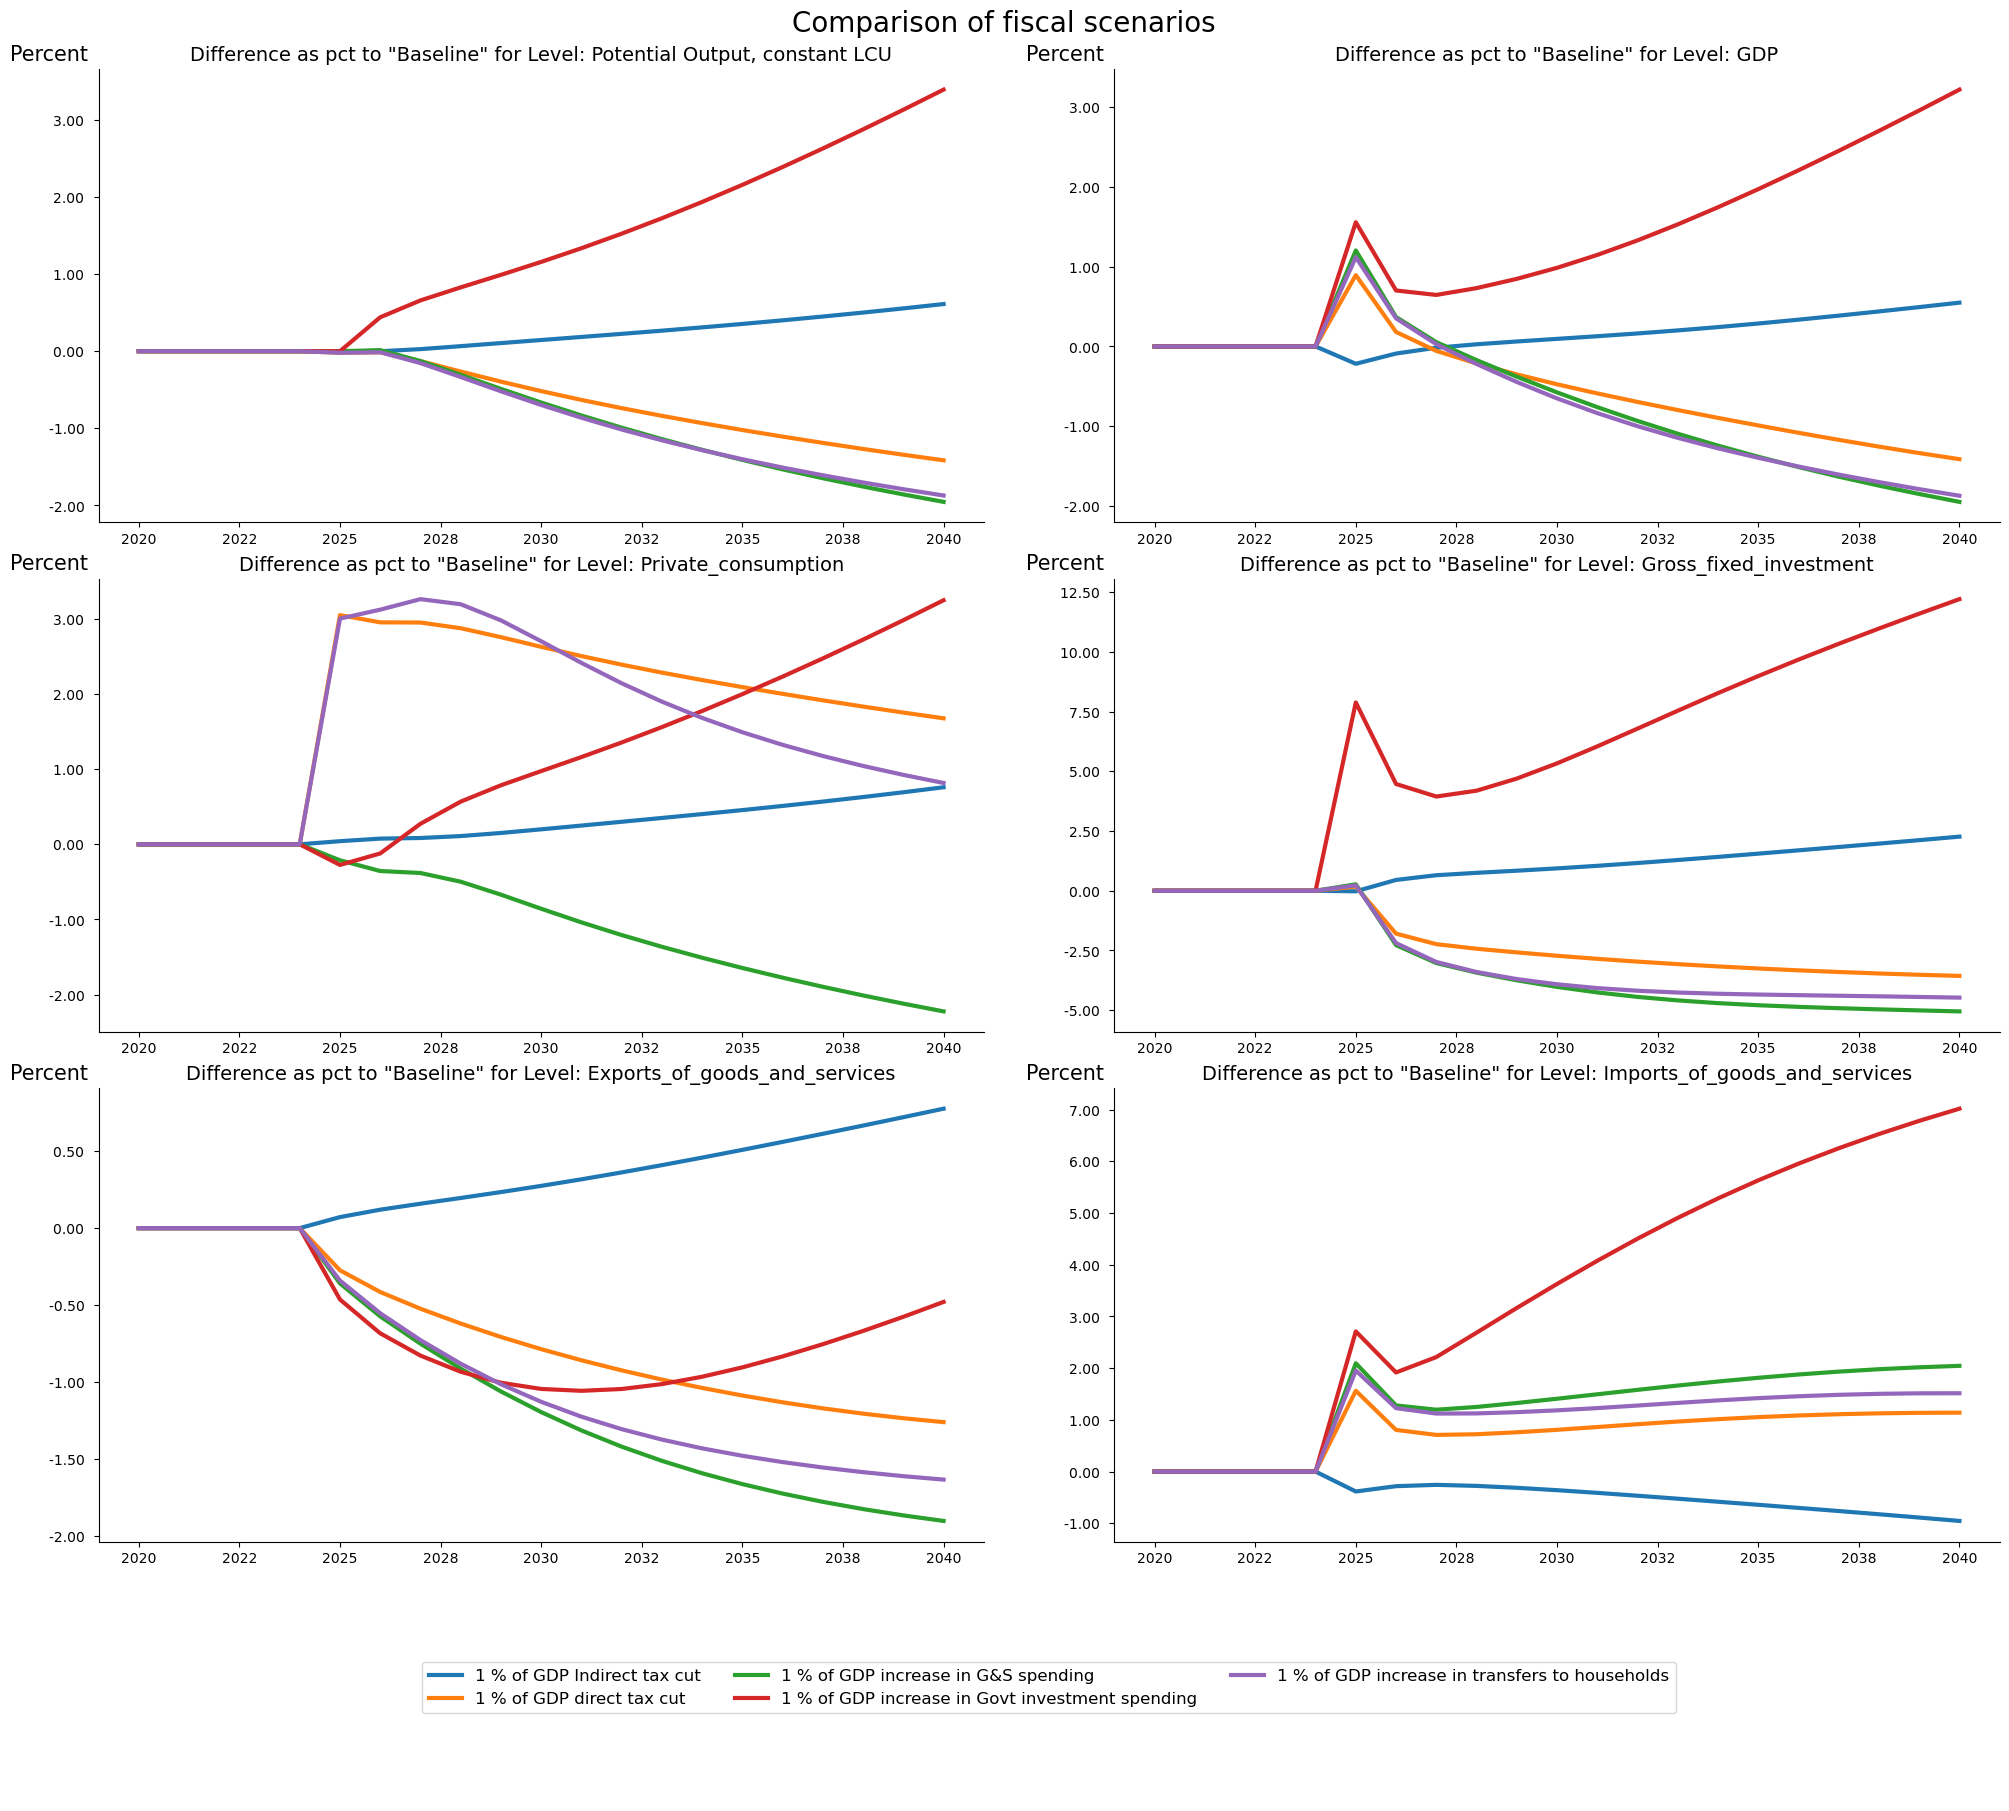

In [16]:
with themodel.keepswitch(scenarios='Baseline|1 % of GDP Indirect tax cut|1 % of GDP direct tax cut|1 % of GDP increase in G&S spending|1 % of GDP increase in Govt investment spending|1 % of GDP increase in transfers to households'):
    themodel.keep_plot(f'{Cty}NYGDPPOTLKN {Cty}NYGDPMKTPKN {Cty}NECONPRVTKN {Cty}NEGDIFTOTKN {Cty}NEEXPGNFSKN {Cty}NEIMPGNFSKN',
                       start=2020, end=2040,diffpct=True,samefig=True,legend=True,title="Comparison of fiscal scenarios");


For Indonesia, the GDP results appear to be consistent with expectations.  Fiscal expansion of all types boosted demand and GDP in the short run.  However, the long run the impact depends on the impact of the spending on potential output.  Sustained increased investment spending served to increase the capital stock and contribute to higher potential and actual GDP.  Spending that focused on consumption or transfers caused potential to decrease, with the principle engine being decreased investment spending, presumably because increased deficits and debt tended to crowd out private-sector investment.  On the other hand transfers to households and decreased direct taxation tended to benefit households, although this impact declined over time due to the decline in potential GDP.  The cut in indirect taxes tended to generate small but persistent benefits, presumably due to lower prices for domestically produced goods with benefits to both exports and import competing goods.

### Impacts on the fiscal accounts

The following command shows the impacts on several of the main fiscal indicators.

In [17]:
import matplotlib.pyplot as plt


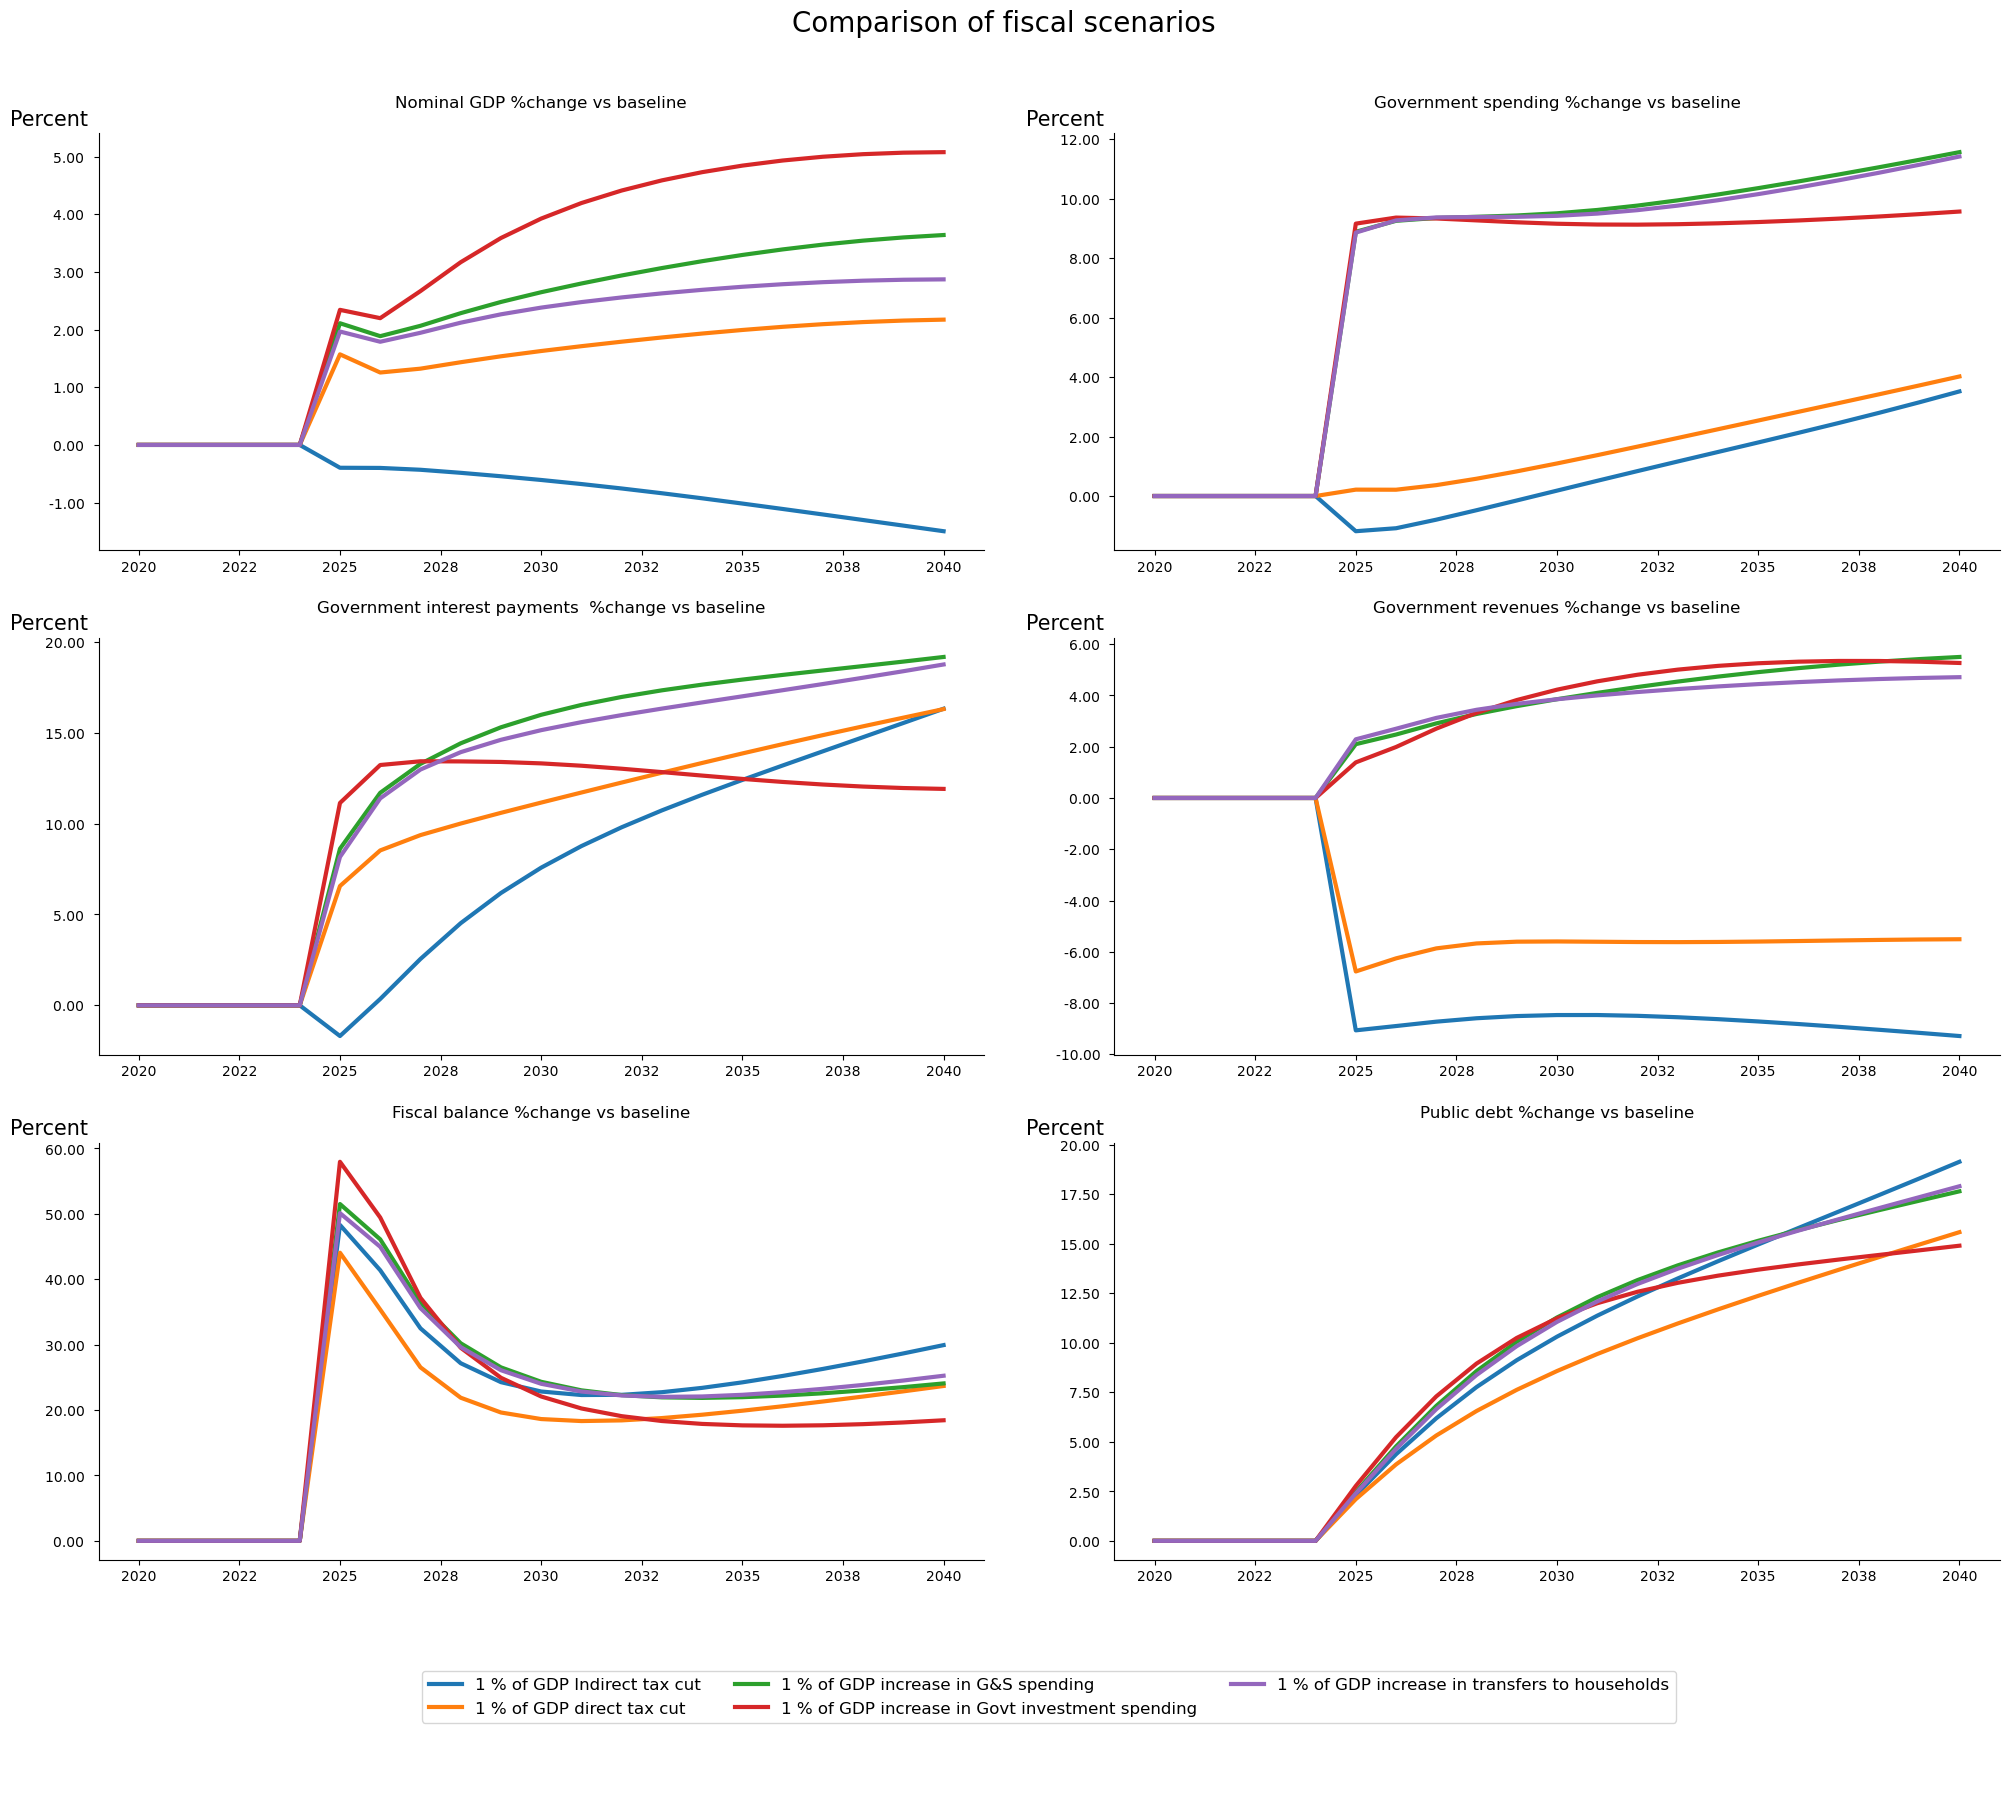

In [18]:
with themodel.keepswitch(
    scenarios='''Baseline|1 % of GDP Indirect tax cut|1 % of GDP direct tax cut|1 % of GDP increase in G&S spending|1 % of GDP increase in Govt investment spending|1 % of GDP increase in transfers to households'''):
    all_figs=themodel.keep_plot(
        f'{Cty}NYGDPMKTPCN {Cty}GGEXPTOTLCN {Cty}GGEXPINTPCN {Cty}GGREVTOTLCN {Cty}GGBALOVRLCN {Cty}GGDBTTOTLCN',
        start=2020, end=2040,diffpct=True,samefig=True,legend=True,title="Comparison of fiscal scenarios\n",showfig=False)
    
#The combined figures are called onefig
figs = all_figs['onefig']
figs.axes[0].set_title("\nNominal GDP %change vs baseline\n")
figs.axes[1].set_title("\nGovernment spending %change vs baseline\n")
figs.axes[2].set_title("\nGovernment interest payments  %change vs baseline\n")
figs.axes[3].set_title("\nGovernment revenues %change vs baseline\n")
figs.axes[4].set_title("\nFiscal balance %change vs baseline\n")
figs.axes[5].set_title("\nPublic debt %change vs baseline\n")
plt.show()

Note that:
* Nominal GDP is increased in all scenarios, mainly reflecting the inflationary impact of the scenario (most scenarios saw real GDP decline).  
* The fiscal account deteriorates in all scenarios as compared with the baseline.
    * Nominal spending increases even in the tax scenarios, but here the driver is increased interest payments as other elements of spending were held constant.
    * Although interest payments as a percent of their initial level are up a lot, the increase as a percent of GDP (see next set of charts is less pronounced).
    * Revenues improve in the spending scenarios because of higher nominal GDP.
    * The fiscal balance deteriorates (becomes more negative) with the extent of the deterioration smallest in the scenarios where real GDP growth is increasing of hit less hard.
    * Public debt is higher in all scenarios

#### Fiscal impacts as a percent of GDP

As observed. higher inflation (due to increased demand in the early years of the simulation) mean that both revenues and expenditures are higher in the simulation scenarios.  

To correct for this effect, the following charts show the results as a percent of GDP.  Here the inflation influences both the numerator and the denominator, so just the net effect is drawn.


In [19]:
# Uncomment to display the mnemonics and desriptions of the general gobernment (GG) expenditure items 
# (EXP) in nominal local currency (CN)
#themodel[f'{Cty}GGEXP*CN'].des  

In [20]:
for key,df in themodel.keep_solutions.items():
    df[f'{Cty}GGBALOVRLCN_']=df[f'{Cty}GGBALOVRLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGEXPTOTLCN_']=df[f'{Cty}GGEXPTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGREVTOTLCN_']=df[f'{Cty}GGREVTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGEXPINTPCN_']=df[f'{Cty}GGEXPINTPCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGDBTTOTLCN_']=df[f'{Cty}GGDBTTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100    
    themodel.keep_solutions[key]=df  


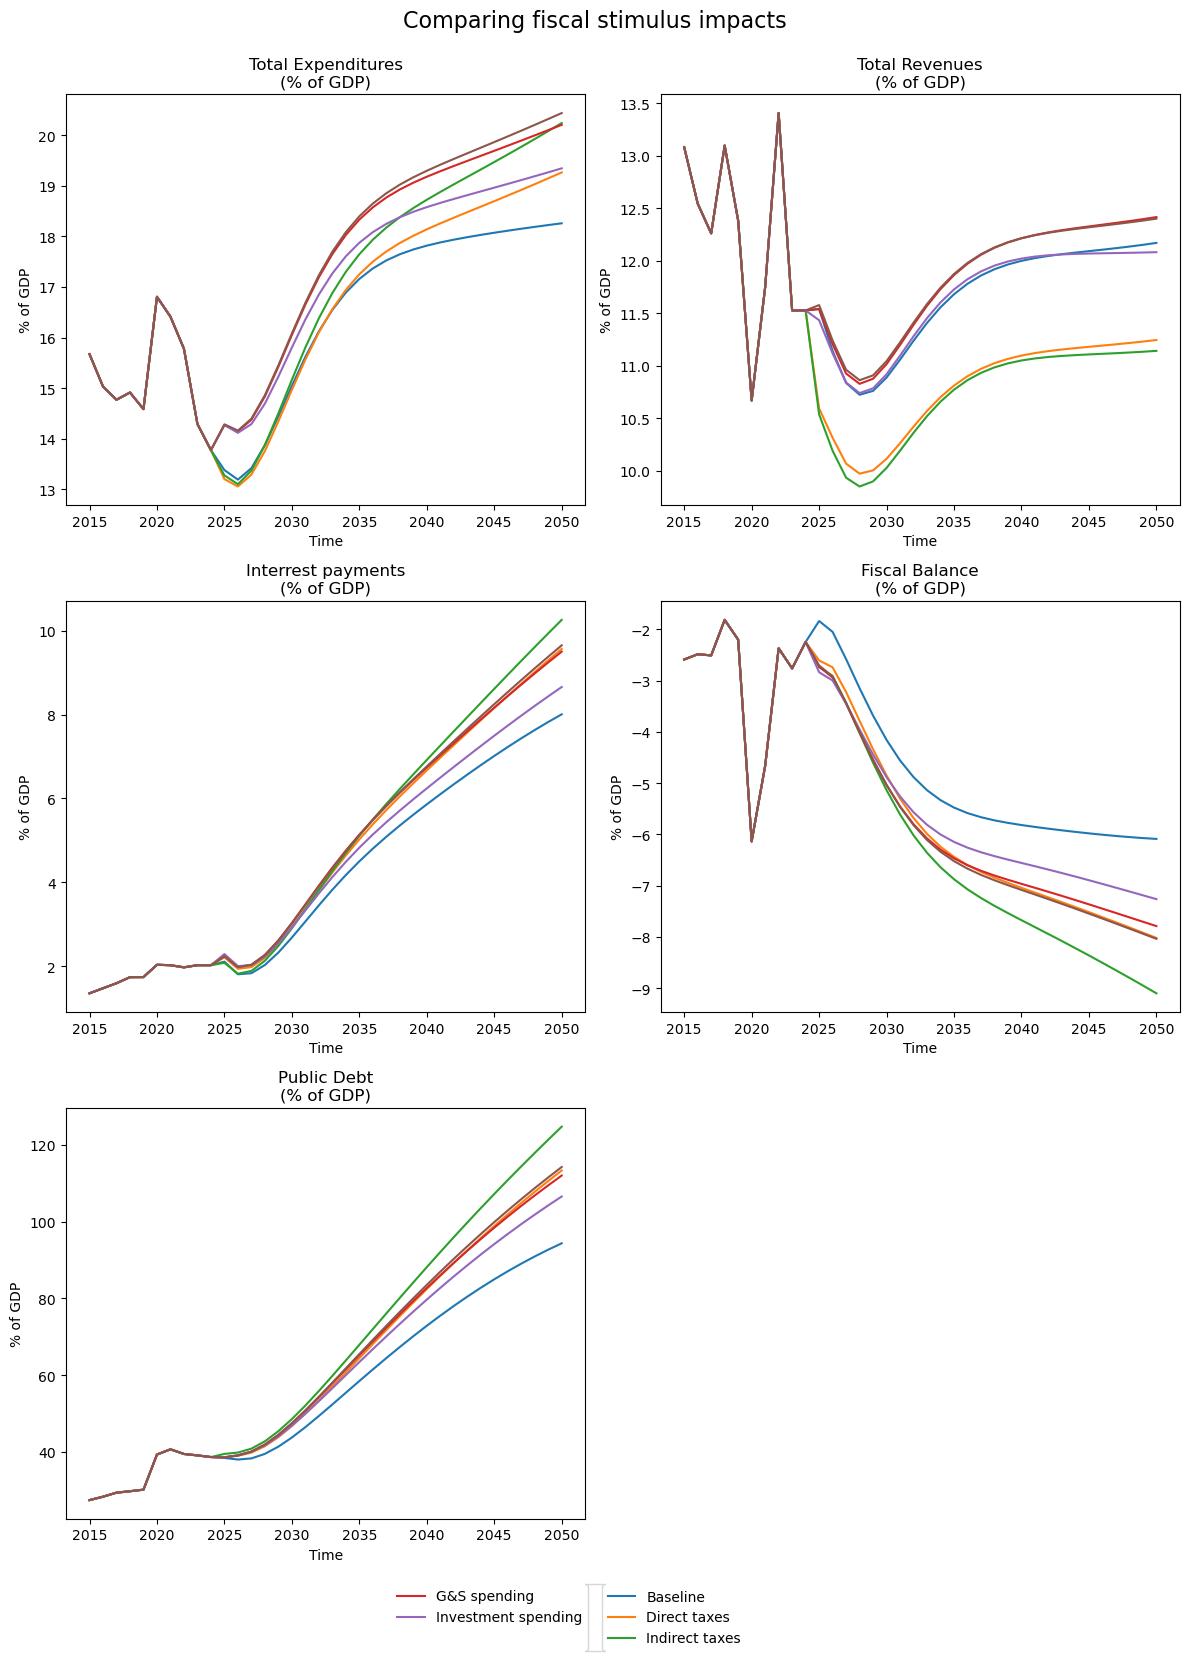

In [21]:
base = themodel.keep_solutions['Baseline'].loc[2015:]
InDirect = themodel.keep_solutions['1 % of GDP Indirect tax cut'].loc[2015:]
GoodsServices = themodel.keep_solutions['1 % of GDP increase in G&S spending'].loc[2015:]
Invest = themodel.keep_solutions['1 % of GDP increase in Govt investment spending'].loc[2015:]
Transfers = themodel.keep_solutions['1 % of GDP increase in transfers to households'].loc[2015:]
Direct = themodel.keep_solutions['1 % of GDP direct tax cut'].loc[2015:]
                                 

figcombo,axs=plt.subplots(3,2,figsize=(12,16))
i=0

vars=['GGEXPTOTLCN','GGREVTOTLCN','GGEXPINTPCN','GGBALOVRLCN','GGDBTTOTLCN']
for idx,var in enumerate(vars):
    row = idx // 2  # Calculate the row index based on the two-column grid
    col = idx % 2
    axs[row,col].plot(base[f'{Cty}{var}_'],label='Baseline')        
    axs[row,col].plot(Direct[f'{Cty}{var}_'],label='Direct taxes')        
    axs[row,col].plot(InDirect[f'{Cty}{var}_'],label='Indirect taxes')            
    axs[row,col].plot(GoodsServices[f'{Cty}{var}_'],label='G&S spending')            
    axs[row,col].plot(Invest[f'{Cty}{var}_'],label='Investment spending')  
    axs[row,col].plot(Transfers[f'{Cty}{var}_'],label='Transfers')               
    axs[row,col].set_ylabel('% of GDP')
    axs[row,col].set_xlabel('Time')

axs[0,0].set_title('Total Expenditures\n(% of GDP)')    
axs[0,1].set_title('Total Revenues\n(% of GDP)')    
axs[1,0].set_title('Interrest payments\n(% of GDP)')    
axs[1,1].set_title('Fiscal Balance\n(% of GDP)')    
axs[2,0].set_title('Public Debt\n(% of GDP)')    

#delete the blank chart
figcombo.delaxes(axs[2, 1])

# Add a joint legend below the subplots with only the first two elements
handles, labels = axs[0,0].get_legend_handles_labels()

#Use only the labels of the first six series in the legend
figcombo.legend(handles[:5], labels[:5], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=False, ncol=2,mode="expand")
figcombo.suptitle("Comparing fiscal stimulus impacts\n", fontsize=16)
# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()




* Spending as a percent of GDP increases by as much as 2 percent of GDP, the result of the original bump up in spending plus increased interest payments as the debt rises.
* Revenues as a percent of GDP are down in the tax reduction scenarios, but up somewhat in the spending scenarios -- presumably reflecting a switch in the mix of total expenditure towards categories that are relatively highly taxed.
* Interest payments rise by as much as 3 percent of GDP by the end of the period due to higher debt levels and because of higher interest rates as debt to GDP rates rise.
* Higher debt and fiscal borrowing will translate into increased competition for domestic and foreign savings, crowding out private sector investment
* The fiscal balance deteriorates by one and three percent of GDP, with differences reflecting differences in real GDP and inflation impacts, and revenue impacts.
* Debt rises by more than 30 percent of GDP as the permanent 1 percent increase in spending accumulates over time.

## Non fiscal simulations

Three non-fiscal scenarios were run.  The first a temporary increase in the monetary policy interest rate, the second a 10 percent depreciation and the final a permanent $20 increase in the price of crude_petrol.

### Monetary policy shock

In this shock, it is assumed that the central bank raises its policy rate by 1 percentage point for 1 year.


In [22]:
Mpol=bline.copy()
Mpol=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

Mpol=themodel.fix(Mpol,f'{Cty}FMLBLPOLYFR',2025,2025) # One year shock to MP but then let the equation take over.
Mpol=Mpol.mfcalc(f'<2025 2025> {Cty}FMLBLPOLYFR_X ={Cty}FMLBLPOLYFR_X   + 1')


The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN
The folowing variables are fixed
IDNFMLBLPOLYFR


In [23]:
#solve the model.
tempdf = themodel(Mpol,silent=1,keep=f'1 ppt increase in policy rate in 2025')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']

themodel.lastdf.loc[2020:2030,"IDNFMLBLPOLYFR"]/themodel.basedf.loc[2020:2030,"IDNFMLBLPOLYFR"]

2020    1.000000
2021    1.000000
2022    1.000000
2023    1.000000
2024    1.000000
2025    1.250000
2026    1.070953
2027    0.994469
2028    0.980845
2029    0.986026
2030    0.993497
Name: IDNFMLBLPOLYFR, dtype: float64

### Exchange rate depreciation

This shock assumes a depreciation of the currency by 10 percent in 2025.


In [24]:
Mpol_exr=bline.copy()
#Mpol_exr=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

Mpol_exr=themodel.fix(Mpol,f'{Cty}PANUSATLS',2025,2050) # One year shock to MP but then let the equation take over.
Mpol_exr=Mpol_exr.mfcalc(f'<2025 2050> {Cty}PANUSATLS_X ={Cty}PANUSATLS_X * 1.1')


The folowing variables are fixed
IDNPANUSATLS


In [25]:
#solve the model.
tempdf = themodel(Mpol_exr,silent=1,keep=f'Permanent 10 percent depreciation in 2025')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']

themodel.lastdf.loc[2020:2030,"IDNPANUSATLS"]/themodel.basedf.loc[2020:2030,"IDNPANUSATLS"]

2020    1.0
2021    1.0
2022    1.0
2023    1.0
2024    1.0
2025    1.1
2026    1.1
2027    1.1
2028    1.1
2029    1.1
2030    1.1
Name: IDNPANUSATLS, dtype: float64

### TFP Shock

This shock explores the effect of a permanent increase in the level of TFP by 1 percent beginning in 2025.


In [26]:
TFP=bline.copy()
TFP=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

#TFP=themodel.fix(Mpol,f'{Cty}PANUSATLS',2025,2050) # One year shock to MP but then let the equation take over.
TFP=TFP.mfcalc(f'<2025 2050> {Cty}NYGDPTFP ={Cty}NYGDPTFP * 1.01')


The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


In [27]:
#solve the model.
tempdf = themodel(TFP,silent=1,keep=f'A permanent 1 percent increase in TFP levels')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']

themodel.lastdf.loc[2020:2030,"IDNNYGDPTFP"]/themodel.basedf.loc[2020:2030,"IDNNYGDPTFP"]

2020    1.00
2021    1.00
2022    1.00
2023    1.00
2024    1.00
2025    1.01
2026    1.01
2027    1.01
2028    1.01
2029    1.01
2030    1.01
Name: IDNNYGDPTFP, dtype: float64

### A permanent 20 percent increase in oil prices

This shock explores the sensitivity of the model to a permanent \$20 increase in global oil and natural gas prices beginning in 2025.  The natural gas price are assumed to rise proportionately to a $20 increase in world crude oil prices.


In [28]:
themodel['WLDF*GAS*'].des

WLDFNGAS_EUR            : Natural gas
WLDFNGAS_EUR_VALUE_2010 : WLDFNGAS_EUR_VALUE_2010


In [29]:
Oil=bline.copy()
Oil=themodel.fix(bline,f'{GGexp}') # Freeze spending levels 

# scenario to raise oil prices.  Assume that natural gas prices increase
# by a similar margin as a $20 increase in crude oil prices
Oil=Oil.mfcalc(
    f'<2025 2050> WLDFNHAS_EUR = WLDFNHAS_EUR * (WLDFCRUDE_PETRO+20)/WLDFCRUDE_PETRO')
Oil=Oil.mfcalc(
    f'<2025 2050> WLDFCRUDE_PETRO = WLDFCRUDE_PETRO + 20')


The folowing variables are fixed
IDNGGEXPCAPTCN
IDNGGEXPGNFSCN
IDNGGEXPTOTHCN
IDNGGEXPTSOCCN


In [30]:
#solve the model.
tempdf = themodel(Oil,silent=1,keep=f'A permanent 20 increase in global crude-oil prices')
#themodel.lastdf['IDNNECONGOVTCN']/themodel.basedf['IDNNECONGOVTCN']



### Summary  impacts of non-fiscal scenarios

The following graphs show the change in the main macroeconomic indicators (Inflation, proxied here by the inflation rate of household consumption), real GDP, and changes in the current account, fiscal balances and debt levels expressed as a percent of GDP.

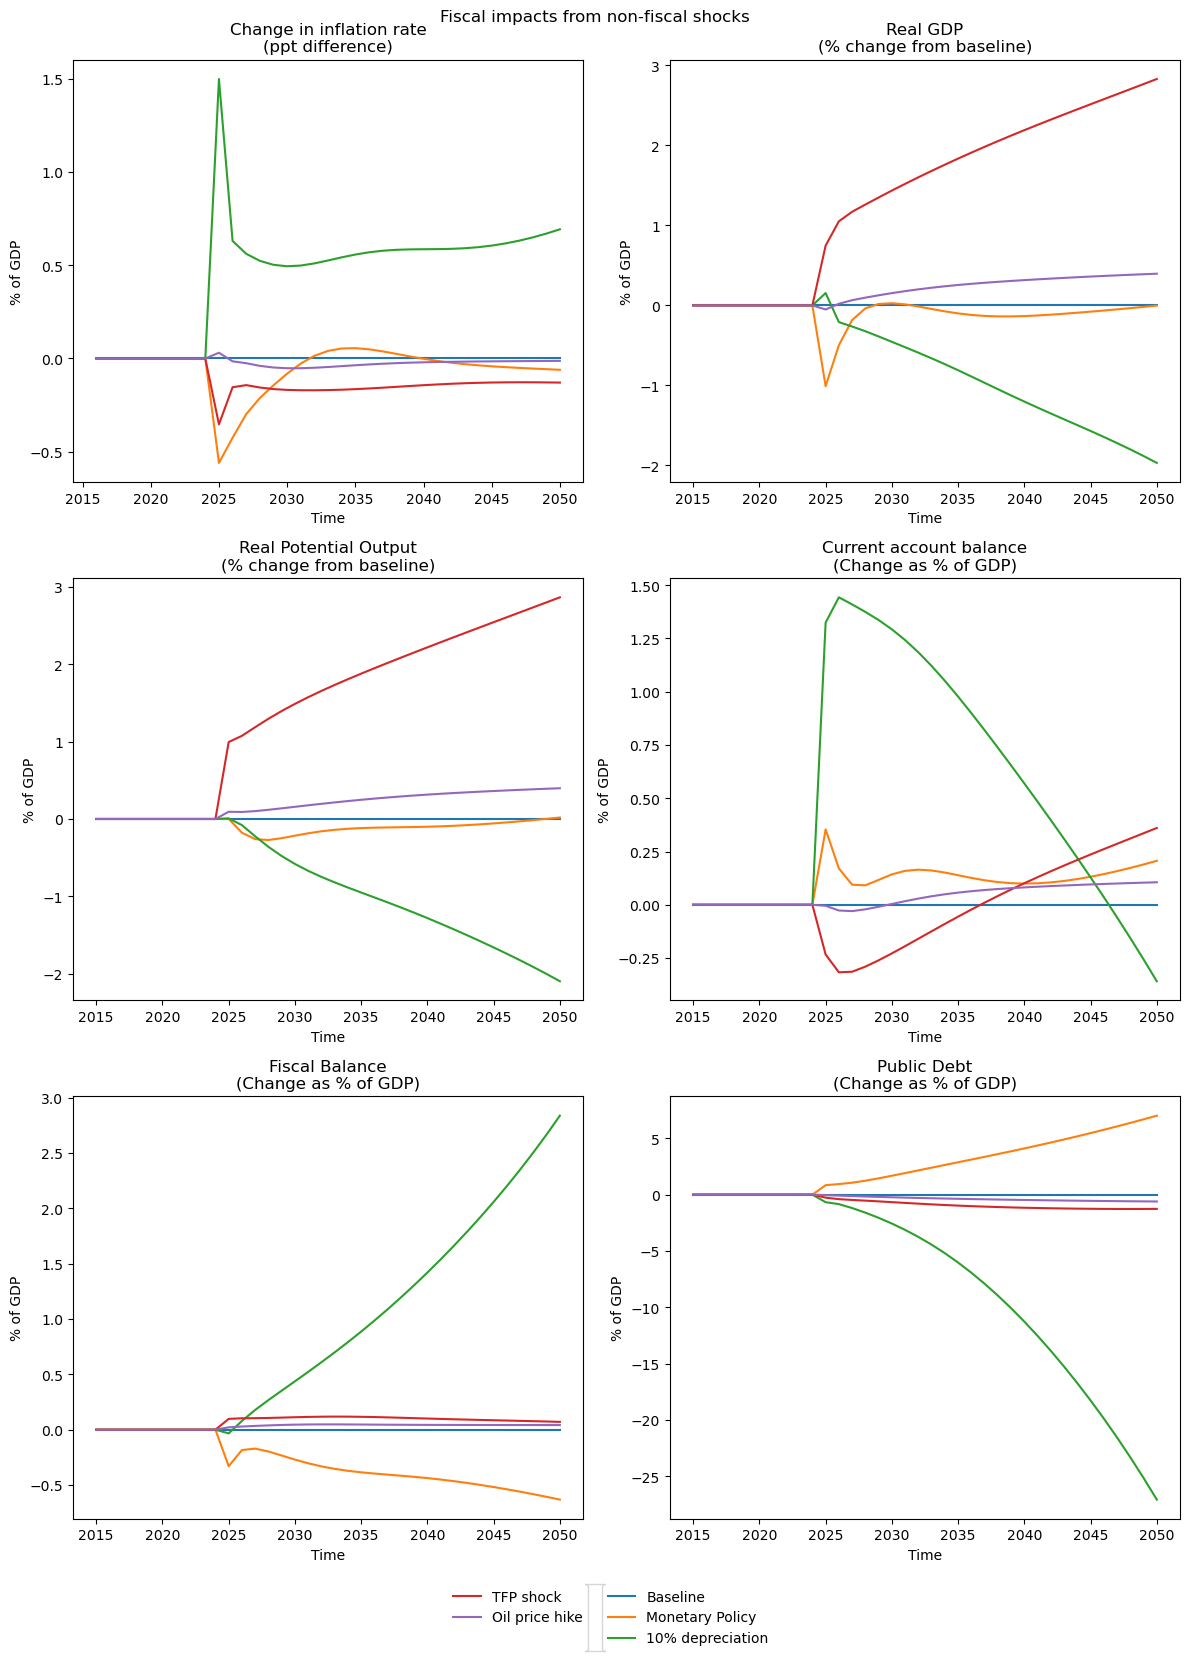

In [31]:


                               
for key,df in themodel.keep_solutions.items():
    df[f'{Cty}NECONPRVTXN_COMP']=(df[f'{Cty}NECONPRVTXN'].pct_change()-base[f'{Cty}NECONPRVTXN'].pct_change())*100
    df[f'{Cty}NYGDPMKTPKN_COMP']=(df[f'{Cty}NYGDPMKTPKN']/base[f'{Cty}NYGDPMKTPKN']-1)*100
    df[f'{Cty}NYGDPPOTLKN_COMP']=(df[f'{Cty}NYGDPPOTLKN']/base[f'{Cty}NYGDPPOTLKN']-1)*100
    df[f'{Cty}BNCABFUNDCN_COMP']=((df[f'{Cty}BNCABFUNDCN']/df[f'{Cty}NYGDPMKTPCN'])-(base[f'{Cty}BNCABFUNDCN']/base[f'{Cty}NYGDPMKTPCN']))*100
    df[f'{Cty}GGBALOVRLCN_COMP']=((df[f'{Cty}GGBALOVRLCN']/df[f'{Cty}NYGDPMKTPCN'])-(base[f'{Cty}GGBALOVRLCN']/base[f'{Cty}NYGDPMKTPCN']))*100
    df[f'{Cty}GGDBTTOTLCN_COMP']=((df[f'{Cty}GGDBTTOTLCN']/df[f'{Cty}NYGDPMKTPCN'])-(base[f'{Cty}GGDBTTOTLCN']/base[f'{Cty}NYGDPMKTPCN']))*100
    themodel.keep_solutions[key]=df      
 
base = themodel.keep_solutions['Baseline'].loc[2015:]
MP = themodel.keep_solutions['1 ppt increase in policy rate in 2025'].loc[2015:]
EXR = themodel.keep_solutions['Permanent 10 percent depreciation in 2025'].loc[2015:]
TFP = themodel.keep_solutions['A permanent 1 percent increase in TFP levels'].loc[2015:]
Oil = themodel.keep_solutions['A permanent 20 increase in global crude-oil prices'].loc[2015:]

figcombo1,axs=plt.subplots(3,2,figsize=(12,16))
i=0

vars=['NECONPRVTXN','NYGDPMKTPKN','NYGDPPOTLKN','BNCABFUNDCN','GGBALOVRLCN','GGDBTTOTLCN']
for idx,var in enumerate(vars):
    row = idx // 2  # Calculate the row index based on the two-column grid
    col = idx % 2
    axs[row,col].plot(base[f'{Cty}{var}_COMP'],label='Baseline')        
    axs[row,col].plot(MP[f'{Cty}{var}_COMP'],label='Monetary Policy')  
    axs[row,col].plot(EXR[f'{Cty}{var}_COMP'],label='10% depreciation')  
    axs[row,col].plot(TFP[f'{Cty}{var}_COMP'],label='TFP shock')        
    axs[row,col].plot(Oil[f'{Cty}{var}_COMP'],label='Oil price hike')  
    axs[row,col].set_ylabel('% of GDP')
    axs[row,col].set_xlabel('Time')

axs[0,0].set_title('Change in inflation rate\n(ppt difference)')    
axs[0,1].set_title('Real GDP\n(% change from baseline)')    
axs[1,0].set_title('Real Potential Output\n(% change from baseline)')    
axs[1,1].set_title('Current account balance\n(Change as % of GDP)')    
axs[2,0].set_title('Fiscal Balance\n(Change as % of GDP)')    
axs[2,1].set_title('Public Debt\n(Change as % of GDP)')    


# Add a joint legend below the subplots with only the first two elements
handles, labels = axs[0,0].get_legend_handles_labels()

#Use only the labels of the first six series in the legend
figcombo1.legend(handles[:6], labels[:6], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=False, ncol=2,mode="expand")
figcombo1.suptitle("Fiscal impacts from non-fiscal shocks")
# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

In [32]:
themodel['IDNNYGDP*KN'].des


IDNNYGDPDISCKN : Statistical_discrepancy
IDNNYGDPFCSTKN : GDP_factor_cost
IDNNYGDPMKTPKN : GDP
IDNNYGDPPOTLKN : Potential Output, constant LCU


As might be expected, effects across these scenarios are more divergent.  

**Inflation**
Higher oil prices and an exchange rate depreciation both are inflationary at least in the short-run.  The inflation impact in the oil scenario is much smaller than in the depreciation scenario and dissipates quite rapidly  as the economy adjusts. In contrast , **there appears to be a permanent increase in inflation in the exchange rate scenario -- odd.**

Both the TFP shock and the monetary policy tightening contribute to declines in inflation.  The TFP shock is deflationary because it raises potential output and therefore open up a negative output gap, at least initially.  Over time this effect diminished but does not seem to go away **(odd)**. In contrast the monetary policy shock which also induces an increase in the output gap (due to lower demand) in the short run, tends to recover its pre-shock inflation rate.

**There is something wrong in the inflation response,.  Inflation should return to its pre-shock level but it really is not doing so in any of the scenarios. **

The permanent increase in TFP translates fairly quickly into higher GDP, and GDP continues to rise -- reflecting stronger potential output.  While the initial increase in TFP will have boosted potential the subsequent increase reflects higher investment induced by the increased productivity of capital (and labor).

**The potential impact is too large (triple the initial TFP shock) should be more like 1.3-1.5 or so.  Whats happening to labor? Is this a  non-oil GDP effect**


#### Real Gdp impacts of non-fiscal simulations

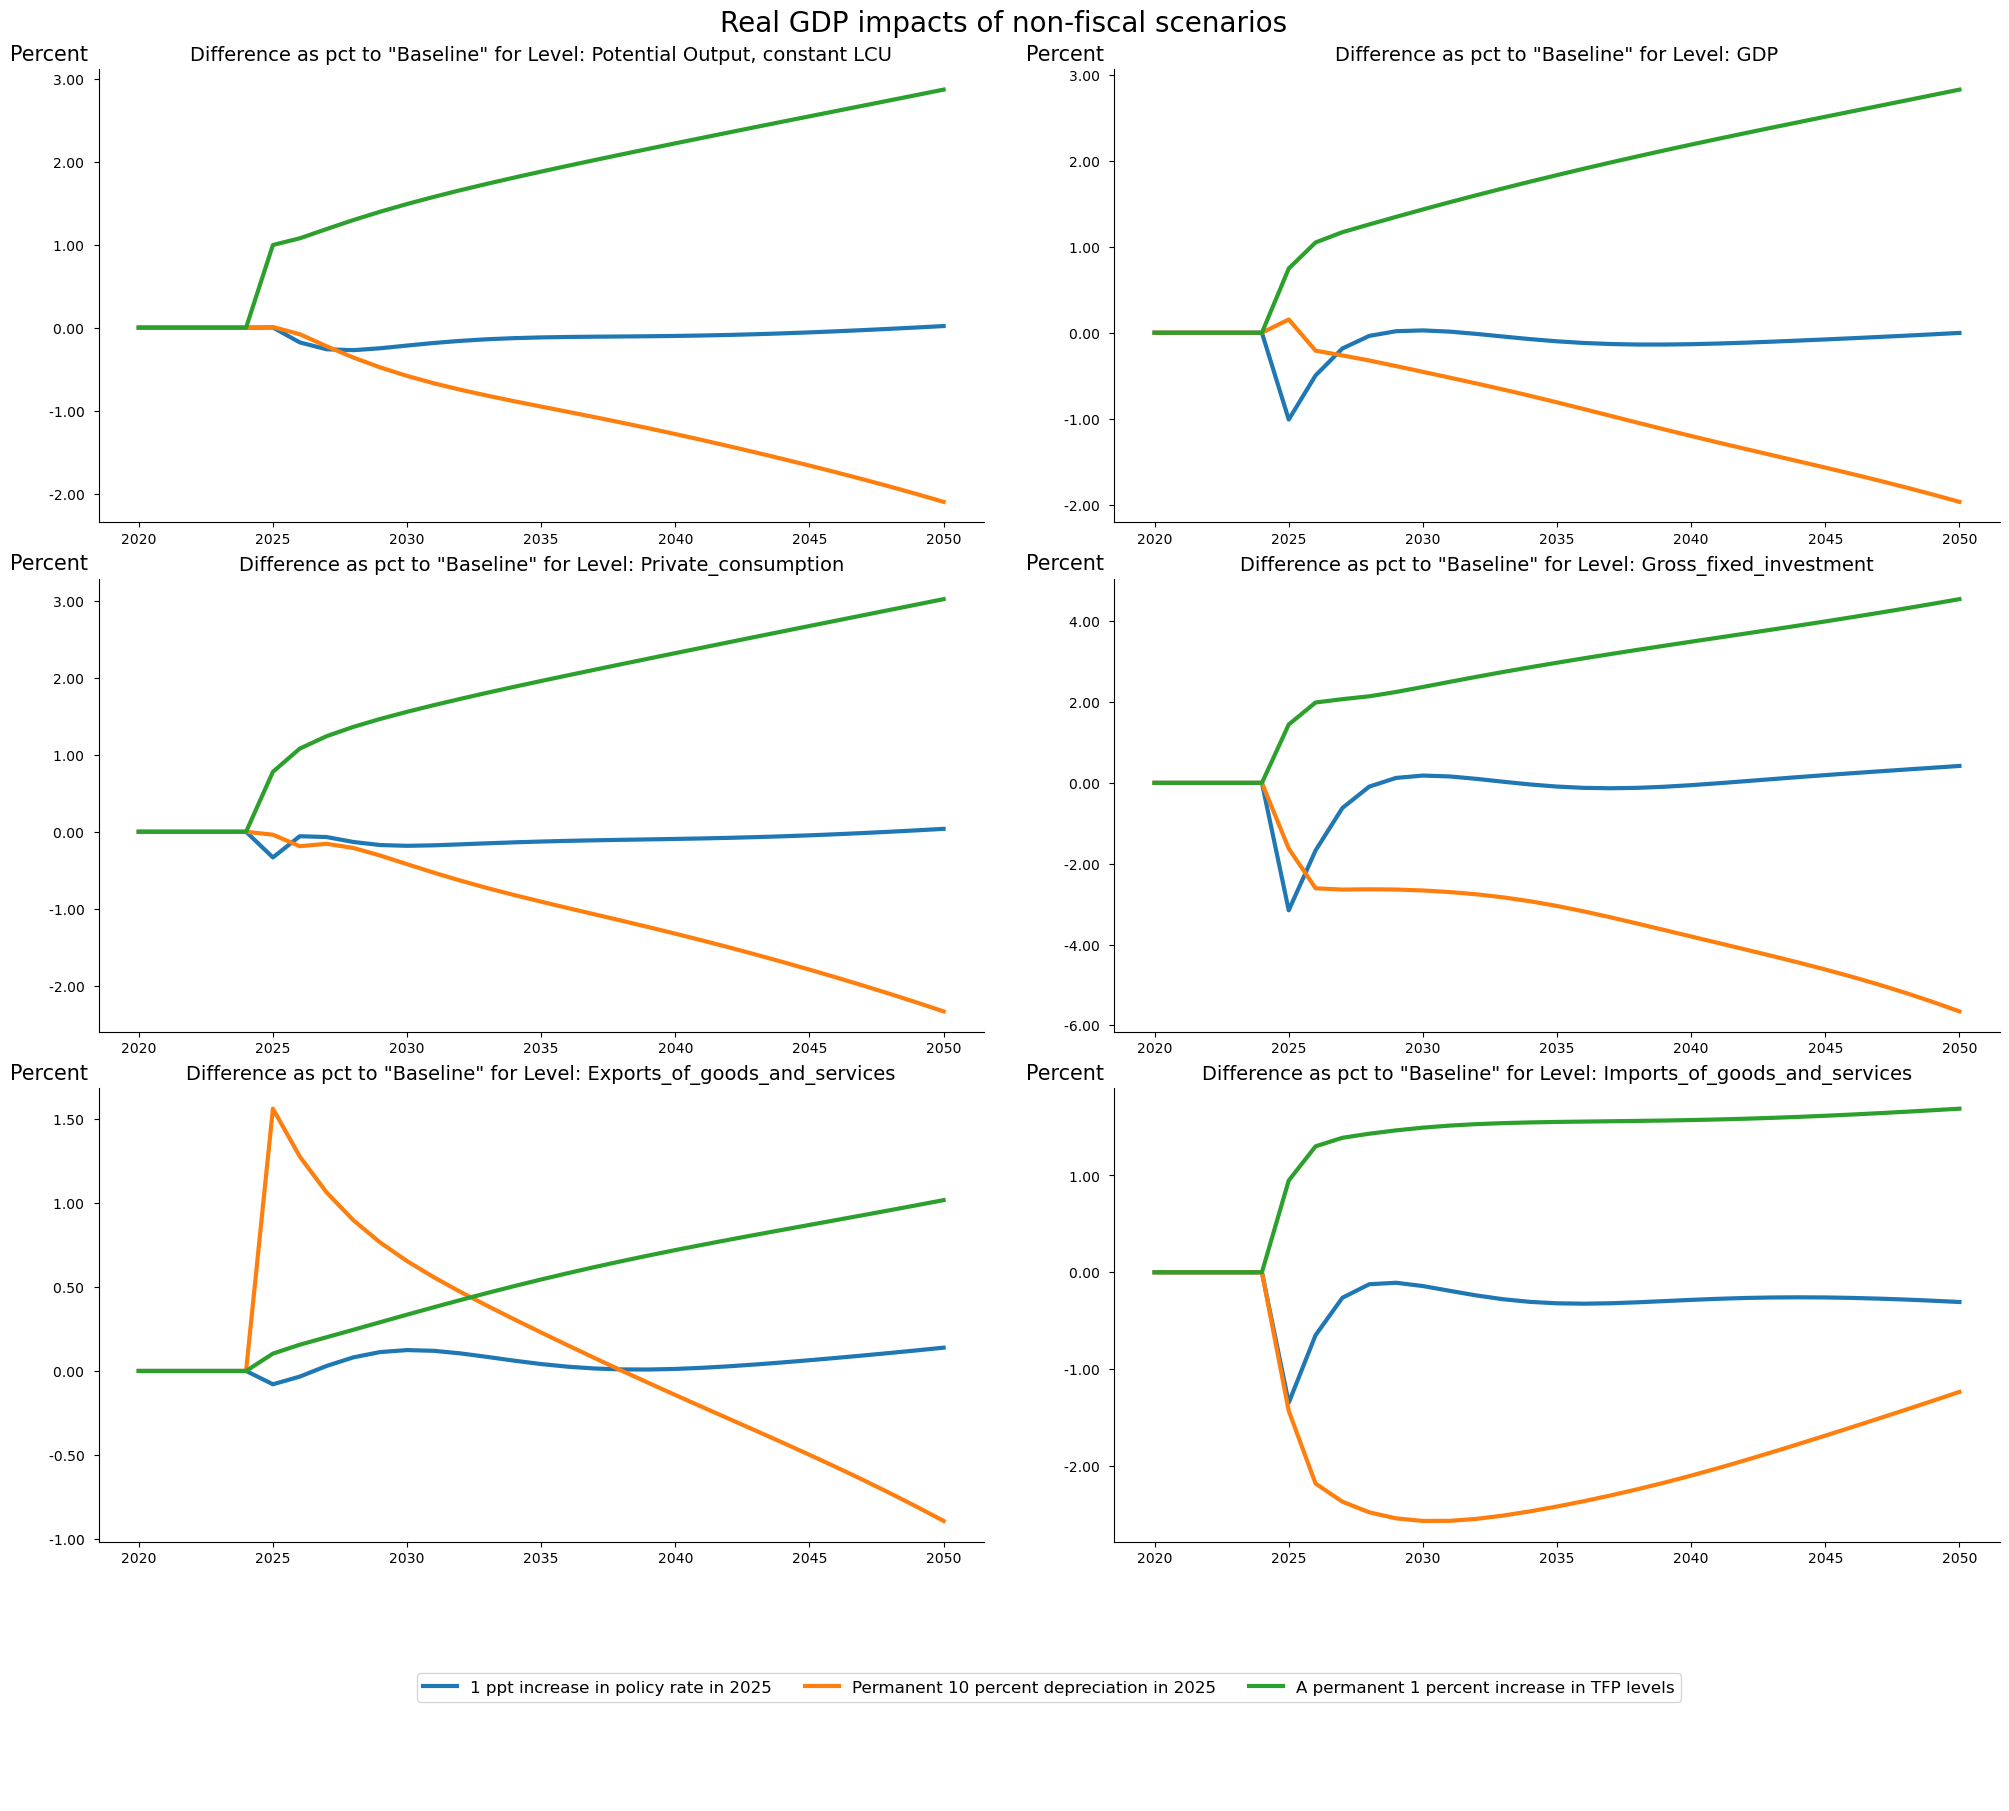

In [33]:
with themodel.keepswitch(scenarios='Baseline|1 ppt increase in policy rate in 2025|Permanent 10 percent depreciation in 2025|A permanent 1 percent increase in TFP levels|A permanent 20 increase in oil global crude oil prices'):
    themodel.keep_plot(f'{Cty}NYGDPPOTLKN {Cty}NYGDPMKTPKN {Cty}NECONPRVTKN {Cty}NEGDIFTOTKN {Cty}NEEXPGNFSKN {Cty}NEIMPGNFSKN',
                       start=2020, end=2050,diffpct=True,samefig=True,legend=True,title="Real GDP impacts of non-fiscal scenarios");

#### Discussion of real GDP impacts of non-fiscal scenarios

##### The TFP shock (green line)
Potential and real GDP impacts mirror one another, with the TFP shock raising potential output permanently, and with real GDP catching up over-time slowly.  The potential GDP impact rises proportionately over time because the higher output induces additional investment which adds further to potential GDP.  Higher potential and actual GDP translates into increased consumption, exports and imports as the economy adjusts to the higher scale of activity.

##### The monetary policy shock (blue line)
As can be expected a tightening of monetary policy has negative effects on GDP. Higher interest rates and slower growth reduce investment growth which has a modest negative effect on potential output and long-run GDP. Consumer demand mirrors GDP as incomes are reduced modestly as compared with the baseline.  Exports are hurt initially due to high capital costs, but as inflation declines they benefit and by the end of the period the impact is negligible.  Imports are similarly hurt initially but recover most of the losses,  They remain lower than baseline in line with lower domestic demand and GDP.

##### Depreciation (orange line)
The long run effect of the 10 percent depreciation is negative, reflecting higher import costs, which dampen investment and contribute to a cumulative 1.5 percent decline in potential output.  Exports benefit initially as domestic goods become more compEtitive abroad and imports decline as import-competing firms benefit.  However, higher import costs translate into lower real incomes and lower consumption, which persist into the future due to the investment effect on GDP.

##### Oil price hike (red line)

A permanent $20 nominal increase in oil prices has modest impacts on GDP, increasing potential slightly in Indonesia an oil exporter as incomes rise allowing for a modest increase in investment and consumption.  Real non-oil exports decline, mainly because of price effects induced by the additional spending that the higher oil revenues enable, which are in turn reflected in a modest decrease in import volumes.




### Fiscal impacts of non-fiscal scenarios

The depreciation fall in spending is kind of hard to explain.

In [34]:
# Uncomment to display the mnemonics and desriptions of the general gobernment (GG) expenditure items 
# (EXP) in nominal local currency (CN)
themodel[f'{Cty}GGEXP*CN'].des  

IDNGGEXPCAPTCN : Capital_Expenditures
IDNGGEXPCRNTCN : Current_Expenditures
IDNGGEXPCYCLCN : Cyclical component of general government expenditures (millions LCU)
IDNGGEXPGNFSCN : Goods_and_Services
IDNGGEXPINTDCN : Domestic_Debt_Interest_Payments
IDNGGEXPINTECN : External_Debt_Interest_Payments
IDNGGEXPINTPCN : Interest_Payments
IDNGGEXPOTHRCN : All_other_Expenditures_not_classified_elsewhere
IDNGGEXPRECVCN : IDNGGEXPRECVCN
IDNGGEXPSTRLCN : Structurally adjusted general government expenditures (millions LCU)
IDNGGEXPTOTHCN : Other_Transfers
IDNGGEXPTOTLCN : Total_Expenditure
IDNGGEXPTRNSCN : Current_Transfers
IDNGGEXPTSOCCN : Social_Assistance
IDNGGEXPWAGECN : Wages_and_Compensation


In [35]:
for key,df in themodel.keep_solutions.items():
    df[f'{Cty}GGBALOVRLCN_']=df[f'{Cty}GGBALOVRLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGEXPTOTLCN_']=df[f'{Cty}GGEXPTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGREVTOTLCN_']=df[f'{Cty}GGREVTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGEXPINTPCN_']=df[f'{Cty}GGEXPINTPCN']/df[f'{Cty}NYGDPMKTPCN']*100
    df[f'{Cty}GGDBTTOTLCN_']=df[f'{Cty}GGDBTTOTLCN']/df[f'{Cty}NYGDPMKTPCN']*100    
    themodel.keep_solutions[key]=df  


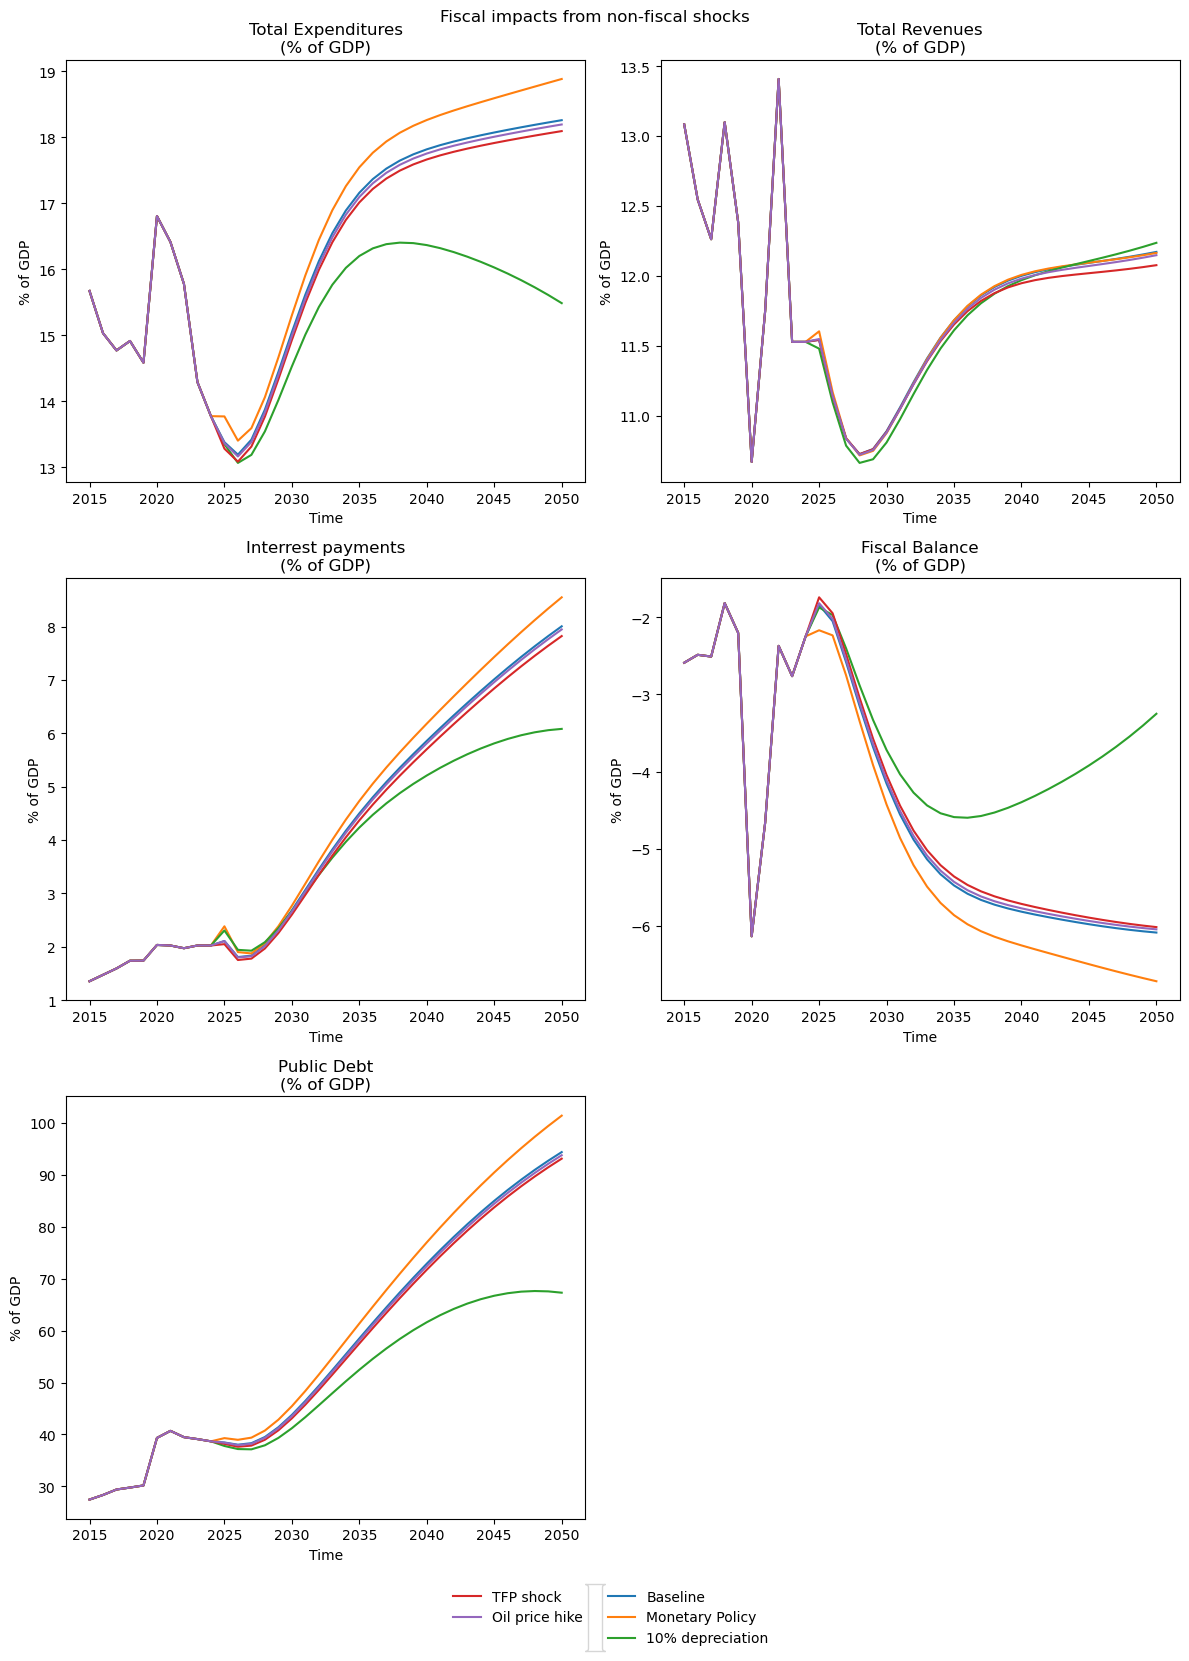

In [36]:
base = themodel.keep_solutions['Baseline'].loc[2015:]
MP = themodel.keep_solutions['1 ppt increase in policy rate in 2025'].loc[2015:]
EXR = themodel.keep_solutions['Permanent 10 percent depreciation in 2025'].loc[2015:]
TFP = themodel.keep_solutions['A permanent 1 percent increase in TFP levels'].loc[2015:]
Oil = themodel.keep_solutions['A permanent 20 increase in global crude-oil prices'].loc[2015:]

                               

figcombo4,axs=plt.subplots(3,2,figsize=(12,16))
i=0

vars=['GGEXPTOTLCN','GGREVTOTLCN','GGEXPINTPCN','GGBALOVRLCN','GGDBTTOTLCN']
for idx,var in enumerate(vars):
    row = idx // 2  # Calculate the row index based on the two-column grid
    col = idx % 2
    axs[row,col].plot(base[f'{Cty}{var}_'],label='Baseline')        
    axs[row,col].plot(MP[f'{Cty}{var}_'],label='Monetary Policy')  
    axs[row,col].plot(EXR[f'{Cty}{var}_'],label='10% depreciation')  
    axs[row,col].plot(TFP[f'{Cty}{var}_'],label='TFP shock')        
    axs[row,col].plot(Oil[f'{Cty}{var}_'],label='Oil price hike')  
    axs[row,col].set_ylabel('% of GDP')
    axs[row,col].set_xlabel('Time')

axs[0,0].set_title('Total Expenditures\n(% of GDP)')    
axs[0,1].set_title('Total Revenues\n(% of GDP)')    
axs[1,0].set_title('Interrest payments\n(% of GDP)')    
axs[1,1].set_title('Fiscal Balance\n(% of GDP)')    
axs[2,0].set_title('Public Debt\n(% of GDP)')    

#delete the blank chart
figcombo4.delaxes(axs[2, 1])

# Add a joint legend below the subplots with only the first two elements
handles, labels = axs[0,0].get_legend_handles_labels()

#Use only the labels of the first six series in the legend
figcombo4.legend(handles[:6], labels[:6], loc='upper center', bbox_to_anchor=(0.5, 0), shadow=False, ncol=2,mode="expand")
figcombo4.suptitle("Fiscal impacts from non-fiscal shocks")
# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()



In [43]:

import pandas as pd
years_of_interest = [2020,2025,2030,2035,2040,2045,2050]
table_df = base[[f'{Cty}GGEXPTOTLCN_',f'{Cty}GGREVTOTLCN_',f'{Cty}GGEXPINTPCN_',f'{Cty}GGBALOVRLCN_',f'{Cty}GGDBTTOTLCN_']]
table_df=table_df[table_df.index.isin(years_of_interest)] 
table_df = table_df.rename(columns={
    f'{Cty}GGEXPTOTLCN_':'GG Expenditure',
    f'{Cty}GGREVTOTLCN_':'GG Revenues',
    f'{Cty}GGEXPINTPCN_':'GG Interest payments',
    f'{Cty}GGBALOVRLCN_':'Fiscal Balance',
    f'{Cty}GGDBTTOTLCN_':'Public Debt',
    })


#separator_row = pd.Series(["Per cent of GDP"], name="Separator", index=table_df.columns) 
#table_df = pd.concat([table_df.iloc[:1],separator_row.to_frame().T, table_df.iloc[1:]])

# Display data transposed with two decimal places
#print(filtered_df.round(2).transpose())
# Display data transposed with two decimal places
print(table_df.round(1).transpose())


                      2020  2025  2030  2035  2040  2045  2050
GG Expenditure        16.8  13.4  15.0  17.2  17.8  18.1  18.3
GG Revenues           10.7  11.5  10.9  11.7  12.0  12.1  12.2
GG Interest payments   2.0   2.1   2.7   4.5   5.9   7.0   8.0
Fiscal Balance        -6.1  -1.8  -4.2  -5.5  -5.8  -6.0  -6.1
Public Debt           39.3  38.5  43.8  58.5  72.9  85.0  94.4
